In [3]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import networkx as nx
from collections import defaultdict
import warnings
from typing import Dict, List, Set, Tuple
from math import comb
warnings.filterwarnings('ignore')

In [4]:
# global settings
# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Dataset directory
dataset_dir = 'dataset'

# GLOBAL CONFIGURATION: Set to True for weighted analysis, False for unweighted
is_weighted = False
file_prefix = 'weighted' if is_weighted else 'unweighted'

print("Power Grid Network Analysis")
print("=" * 50)

# Load all networks and basic statistics
networks = {}
network_stats = []

print("Loading networks...")
for i in range(1, 59):
    try:
        data = loadmat(os.path.join(dataset_dir, f'{i}.mat'))
        adj_matrix = data['A']
        adj_np = adj_matrix.toarray()
        assert (adj_np == adj_np.T).all(), "Adjacency matrix is not symmetric"
        assert np.diag(adj_np).sum() == 0, "Adjacency matrix has self-loops"
        
        # Convert sparse matrix to NetworkX graph
        if is_weighted and 'W' in data:
            # Use distance matrix as weights
            weight_matrix = data['W']
            G = nx.from_scipy_sparse_array(weight_matrix)
            print(f"Network {i}: Using weighted graph with distance matrix")
        else:
            # Use unweighted adjacency matrix
            G = nx.from_scipy_sparse_array(adj_matrix)
            if is_weighted:
                print(f"Network {i}: Warning - 'W' matrix not found, using unweighted")
        
        # Remove self-loops and ensure undirected
        G.remove_edges_from(nx.selfloop_edges(G))
        G = G.to_undirected()
        
        networks[i] = G
        
        # Collect basic statistics
        stats = {
            'network_id': i,
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': nx.density(G),
            'is_connected': nx.is_connected(G)
        }
        network_stats.append(stats)
        
        if i % 10 == 0:
            print(f"Loaded network {i}")
            
    except Exception as e:
        print(f"Error loading network {i}: {e}")

print(f"\nSuccessfully loaded {len(networks)} networks")

Power Grid Network Analysis
Loading networks...
Loaded network 10
Loaded network 20
Loaded network 30
Loaded network 40
Loaded network 50

Successfully loaded 58 networks


In [ ]:
# ============================================================================
# QUESTION 3: FIRST PASSAGE PROBABILITY AND MEAN FIRST PASSAGE TIME
# ============================================================================

def compute_transition_matrix(G: nx.Graph) -> np.ndarray:
    """
    Compute the transition probability matrix for a random walk on graph G.
    P[i,j] = probability of moving from node i to node j.
    """
    n = G.number_of_nodes()
    P = np.zeros((n, n))
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        degree = len(neighbors)
        if degree > 0:
            for neighbor in neighbors:
                P[node, neighbor] = 1.0 / degree
    
    return P


def compute_first_passage_probability(P: np.ndarray, start_node: int, 
                                     target_node: int, max_steps: int) -> np.ndarray:
    """
    Compute first passage probability as a function of time.
    
    Args:
        P: Transition matrix
        start_node: Starting node
        target_node: Target node
        max_steps: Maximum number of steps to simulate
    
    Returns:
        Array of first passage probabilities at each time step
    """
    n = P.shape[0]
    
    # Modify transition matrix: make target node absorbing
    P_absorbing = P.copy()
    P_absorbing[target_node, :] = 0
    P_absorbing[target_node, target_node] = 1.0
    
    # Initialize probability distribution
    prob_dist = np.zeros(n)
    prob_dist[start_node] = 1.0
    
    # Track first passage probabilities
    first_passage_prob = np.zeros(max_steps + 1)
    first_passage_prob[0] = 0 if start_node != target_node else 1.0
    
    # Cumulative probability of reaching target
    cumulative_reached = first_passage_prob[0]
    
    for t in range(1, max_steps + 1):
        # Evolve probability distribution
        prob_dist = P_absorbing.T @ prob_dist
        
        # First passage probability = increase in target node probability
        current_at_target = prob_dist[target_node]
        first_passage_prob[t] = current_at_target - cumulative_reached
        cumulative_reached = current_at_target
    
    return first_passage_prob


def compute_mean_first_passage_time(P: np.ndarray, start_node: int, 
                                   target_node: int) -> float:
    """
    Compute mean first passage time from start_node to target_node.
    Uses the fundamental matrix approach.
    """
    n = P.shape[0]
    
    if start_node == target_node:
        return 0.0
    
    # Create the transient transition matrix (remove target node)
    indices = [i for i in range(n) if i != target_node]
    Q = P[np.ix_(indices, indices)]
    
    # Fundamental matrix: N = (I - Q)^(-1)
    I = np.eye(Q.shape[0])
    try:
        N = np.linalg.inv(I - Q)
    except:
        # If singular, use pseudo-inverse
        N = np.linalg.pinv(I - Q)
    
    # Mean first passage time is sum of rows of N
    m = np.sum(N, axis=1)
    
    # Find index in reduced matrix
    start_idx = indices.index(start_node)
    
    return m[start_idx]


def compute_mfpt_from_superposition(P: np.ndarray, target_node: int) -> float:
    """
    Compute mean first passage time starting from uniform superposition 
    of all nodes except target.
    """
    n = P.shape[0]
    
    # Compute MFPT from each node
    mfpt_values = []
    for i in range(n):
        if i != target_node:
            mfpt = compute_mean_first_passage_time(P, i, target_node)
            mfpt_values.append(mfpt)
    
    # Average over all starting nodes (uniform superposition)
    return np.mean(mfpt_values)


def question1_analysis(G: nx.Graph, network_id: int = 10):
    """
    Complete analysis for Question 1.
    """
    print("\n" + "="*80)
    print(f"QUESTION 1: First Passage Analysis for Network {network_id}")
    print("="*80)
    
    n = G.number_of_nodes()
    print(f"\nNetwork statistics:")
    print(f"  Nodes: {n}")
    print(f"  Edges: {G.number_of_edges()}")
    print(f"  Average degree: {2*G.number_of_edges()/n:.2f}")
    
    # Define nodes of interest (convert to 0-indexed)
    node_1 = 0   # 1st node (0-indexed)
    node_38 = 37 # 38th node (0-indexed)
    node_75 = 74 # 75th node (0-indexed)
    
    # Check if nodes exist
    if node_75 >= n:
        print(f"\nWarning: Node 75 doesn't exist (only {n} nodes). Using last node.")
        node_75 = n - 1
    
    print(f"\nTarget nodes (0-indexed):")
    print(f"  Node 1:  index {node_1}")
    print(f"  Node 38: index {node_38}")
    print(f"  Node 75: index {node_75}")
    
    # Compute transition matrix
    print("\nComputing transition matrix...")
    P = compute_transition_matrix(G)
    
    # Maximum steps
    max_steps = 2 * n
    print(f"Maximum steps: {max_steps} (2n)")
    
    # ========================================================================
    # Part A: First passage probabilities starting from node 38
    # ========================================================================
    print("\n" + "-"*80)
    print("Part A: First Passage Probabilities (starting from node 38)")
    print("-"*80)
    
    target_nodes = [node_1, node_38, node_75]
    target_labels = ["Node 1", "Node 38", "Node 75"]
    fpp_results = {}
    
    for target, label in zip(target_nodes, target_labels):
        print(f"\nComputing FPP to {label}...")
        fpp = compute_first_passage_probability(P, node_38, target, max_steps)
        fpp_results[label] = fpp
        
        # Statistics
        total_prob = np.sum(fpp)
        peak_time = np.argmax(fpp)
        peak_prob = fpp[peak_time]
        
        print(f"  Total probability (reached): {total_prob:.4f}")
        print(f"  Peak at time {peak_time} with prob {peak_prob:.6f}")
    
    # ========================================================================
    # Part B: Mean First Passage Times
    # ========================================================================
    print("\n" + "-"*80)
    print("Part B: Mean First Passage Times to Node 38")
    print("-"*80)
    
    # From node 1 to node 38
    print(f"\nComputing MFPT from Node 1 to Node 38...")
    mfpt_1_to_38 = compute_mean_first_passage_time(P, node_1, node_38)
    print(f"  MFPT(1 → 38) = {mfpt_1_to_38:.2f} steps")
    
    # From node 75 to node 38
    print(f"\nComputing MFPT from Node 75 to Node 38...")
    mfpt_75_to_38 = compute_mean_first_passage_time(P, node_75, node_38)
    print(f"  MFPT(75 → 38) = {mfpt_75_to_38:.2f} steps")
    
    # From uniform superposition to node 38
    print(f"\nComputing MFPT from uniform superposition to Node 38...")
    mfpt_super_to_38 = compute_mfpt_from_superposition(P, node_38)
    print(f"  MFPT(superposition → 38) = {mfpt_super_to_38:.2f} steps")
    
    # ========================================================================
    # Visualization
    # ========================================================================
    
    # fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    ax = plt.figure(figsize=(8, 5)).add_subplot(1,1,1)
    
    # # Plot 1: First passage probabilities (linear scale)
    # ax = axes[0, 0]
    # for label, fpp in fpp_results.items():
    #     ax.plot(fpp, label=label, linewidth=2)
    # ax.set_xlabel('Time (steps)', fontsize=11)
    # ax.set_ylabel('First Passage Probability', fontsize=11)
    # ax.set_title('First Passage Probability from Node 38\n(Linear Scale)', 
    #              fontsize=12, fontweight='bold')
    # ax.legend(fontsize=10)
    # ax.grid(True, alpha=0.3)
    
    # # Plot 2: First passage probabilities (log scale)
    # ax = axes[0, 1]
    # for label, fpp in fpp_results.items():
    #     # Only plot non-zero values
    #     mask = fpp > 0
    #     times = np.arange(len(fpp))[mask]
    #     values = fpp[mask]
    #     ax.semilogy(times, values, label=label, linewidth=2)
    # ax.set_xlabel('Time (steps)', fontsize=11)
    # ax.set_ylabel('First Passage Probability (log scale)', fontsize=11)
    # ax.set_title('First Passage Probability from Node 38\n(Log Scale)', 
    #              fontsize=12, fontweight='bold')
    # ax.legend(fontsize=10)
    # ax.grid(True, alpha=0.3)
    
    # Plot 3: Cumulative first passage probability
    # ax = axes[1, 0]
    for label, fpp in fpp_results.items():
        cumulative = np.cumsum(fpp)
        ax.plot(cumulative, label=label, linewidth=2)
    ax.set_xlabel('Time (steps)', fontsize=11)
    ax.set_ylabel('Cumulative Probability', fontsize=11)
    ax.set_title('Cumulative First Passage Probability\n(Probability of reaching by time t)', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=1.0, color='k', linestyle='--', alpha=0.3)
    
    # Plot 4: Mean First Passage Times (bar chart)
    # ax = axes[1, 1]
    # mfpt_data = {
    #     'From Node 1': mfpt_1_to_38,
    #     'From Node 75': mfpt_75_to_38,
    #     'From Superposition': mfpt_super_to_38
    # }
    # colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    # bars = ax.bar(mfpt_data.keys(), mfpt_data.values(), color=colors, alpha=0.7, edgecolor='black')
    # ax.set_ylabel('Mean First Passage Time (steps)', fontsize=11)
    # ax.set_title('Mean First Passage Time to Node 38', fontsize=12, fontweight='bold')
    # ax.grid(True, alpha=0.3, axis='y')
    
    # # Add value labels on bars
    # for bar, (label, value) in zip(bars, mfpt_data.items()):
    #     height = bar.get_height()
    #     ax.text(bar.get_x() + bar.get_width()/2., height,
    #             f'{value:.1f}',
    #             ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'question3_network{network_id}_analysis.pdf', dpi=500, bbox_inches='tight')
    print(f"\nPlot saved: question3_network{network_id}_analysis.pdf")
    plt.show()
    
    return {
        'fpp_results': fpp_results,
        'mfpt_1_to_38': mfpt_1_to_38,
        'mfpt_75_to_38': mfpt_75_to_38,
        'mfpt_super_to_38': mfpt_super_to_38
    }



RANDOM WALK ANALYSIS FOR POWER TRANSMISSION NETWORKS

Analyzing Network 10
Nodes: 75, Edges: 86

QUESTION 1: First Passage Analysis for Network 10

Network statistics:
  Nodes: 75
  Edges: 86
  Average degree: 2.29

Target nodes (0-indexed):
  Node 1:  index 0
  Node 38: index 37
  Node 75: index 74

Computing transition matrix...
Maximum steps: 150 (2n)

--------------------------------------------------------------------------------
Part A: First Passage Probabilities (starting from node 38)
--------------------------------------------------------------------------------

Computing FPP to Node 1...
  Total probability (reached): 0.4786
  Peak at time 14 with prob 0.005649

Computing FPP to Node 38...
  Total probability (reached): 1.0000
  Peak at time 0 with prob 1.000000

Computing FPP to Node 75...
  Total probability (reached): 0.4308
  Peak at time 4 with prob 0.025000

--------------------------------------------------------------------------------
Part B: Mean First Passage T

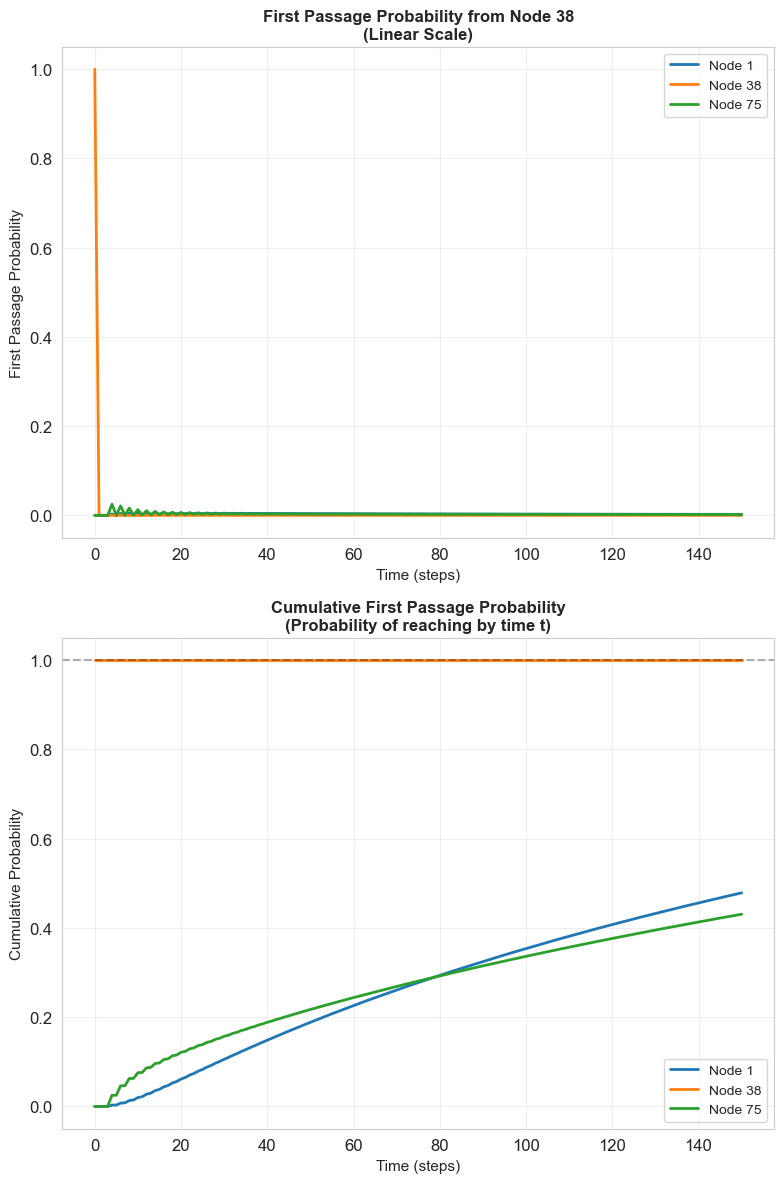

In [22]:
network_id = 10
G = networks[network_id]

print("\n" + "="*80)
print("RANDOM WALK ANALYSIS FOR POWER TRANSMISSION NETWORKS")
print("="*80)
print(f"\nAnalyzing Network {network_id}")
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# Question 1: Analytical approach
q1_results = question1_analysis(G, network_id)

In [ ]:
# ============================================================================
# QUESTION 2: NUMERICAL SIMULATION OF RANDOM WALKS
# ============================================================================

def simulate_single_random_walk(G: nx.Graph, start_node: int, 
                               target_node: int, max_steps: int = 100000) -> int:
    """
    Simulate a single random walk from start_node to target_node.
    Returns the number of steps taken, or max_steps if not reached.
    """
    current = start_node
    steps = 0
    
    while current != target_node and steps < max_steps:
        neighbors = list(G.neighbors(current))
        if not neighbors:
            return max_steps  # Stuck (shouldn't happen in connected graph)
        
        # Choose random neighbor uniformly
        current = np.random.choice(neighbors)
        steps += 1
    
    return steps


def compute_required_simulations(rse_target: float = 0.01) -> int:
    """
    Estimate required number of simulations for given relative standard error.
    RSE = SE/mean = σ/(mean * sqrt(n))
    For RSE target, we need: n = (CV / RSE_target)^2
    """
    return None  # Computed adaptively in main function


def question2_simulation(G: nx.Graph, network_id: int = 10, max_simulations: int = 100000):
    """
    Complete analysis for Question 2: Numerical simulation of random walks.
    Run simulations until RSE (Relative Standard Error) reaches 1% or max_simulations reached.
    """
    print("\n" + "="*80)
    print(f"QUESTION 2: Random Walk Simulation for Network {network_id}")
    print("="*80)
    
    n = G.number_of_nodes()
    
    # Define nodes
    node_1 = 0
    node_38 = 37
    node_75 = 74 if n > 74 else n - 1
    
    print(f"\nSimulating random walks to Node 38")
    print(f"Target Relative Standard Error (RSE): 1%")
    print(f"Maximum simulations: {max_simulations}")
    
    # Target RSE (not CV!)
    rse_target = 0.01
    
    # ========================================================================
    # Run simulations until RSE target achieved or max_simulations reached
    # ========================================================================
    
    results = {}
    
    for start_node, start_label in [(node_1, "Node 1"), (node_75, "Node 75")]:
        print(f"\n" + "-"*80)
        print(f"Simulating: {start_label} → Node 38")
        print("-"*80)
        
        all_times = []
        batch_size = 100
        check_interval = 100  # Check RSE every 100 simulations
        
        current_rse = float('inf')
        total_start_time = time.time()
        
        print(f"\nRunning simulations in batches of {batch_size}...")
        print(f"Checking RSE every {check_interval} simulations")
        print(f"Target RSE: {rse_target*100:.2f}%\n")
        
        # Run simulations until RSE target met or max reached
        batch_num = 0
        while len(all_times) < max_simulations and current_rse > rse_target:
            batch_num += 1
            
            # Run a batch
            batch_start_time = time.time()
            for _ in range(batch_size):
                if len(all_times) >= max_simulations:
                    break
                steps = simulate_single_random_walk(G, start_node, node_38)
                all_times.append(steps)
            batch_duration = time.time() - batch_start_time
            
            # Check RSE periodically
            if len(all_times) % check_interval == 0 or len(all_times) >= max_simulations:
                current_mean = np.mean(all_times)
                current_std = np.std(all_times, ddof=1)
                current_se = current_std / np.sqrt(len(all_times))
                current_rse = current_se / current_mean if current_mean > 0 else float('inf')
                current_cv = current_std / current_mean if current_mean > 0 else float('inf')
                
                elapsed_total = time.time() - total_start_time
                
                status = "✓ TARGET MET!" if current_rse <= rse_target else "continuing..."
                print(f"  n={len(all_times):6d} | Mean={current_mean:8.2f} | "
                      f"SE={current_se:6.2f} | RSE={current_rse*100:5.2f}% | "
                      f"CV={current_cv*100:5.2f}% | {elapsed_total:6.1f}s | {status}")
                
                # If target met, we can stop
                if current_rse <= rse_target:
                    print(f"\n✓ Target RSE achieved with {len(all_times)} simulations!")
                    break
        
        total_duration = time.time() - total_start_time
        
        # Final statistics
        final_mean = np.mean(all_times)
        final_std = np.std(all_times, ddof=1)
        final_se = final_std / np.sqrt(len(all_times))
        final_rse = final_se / final_mean
        final_cv = final_std / final_mean
        
        print(f"\n" + "="*70)
        print(f"FINAL RESULTS: {start_label} → Node 38")
        print("="*70)
        print(f"  Total simulations: {len(all_times)}")
        print(f"  Mean first passage time: {final_mean:.2f} ± {final_se:.2f} steps")
        print(f"  Standard deviation: {final_std:.2f} steps")
        print(f"  Standard error: {final_se:.2f} steps")
        print(f"  Coefficient of variation (CV): {final_cv:.4f} ({final_cv*100:.2f}%)")
        print(f"  Relative standard error (RSE): {final_rse:.4f} ({final_rse*100:.2f}%)")
        print(f"  95% CI: [{final_mean - 1.96*final_se:.2f}, {final_mean + 1.96*final_se:.2f}]")
        print(f"  Min/Max: {min(all_times)} / {max(all_times)} steps")
        print(f"  Median: {np.median(all_times):.2f} steps")
        print(f"  Total computation time: {total_duration:.2f}s")
        
        if final_rse <= rse_target:
            print(f"  ✓ Target RSE of {rse_target*100:.2f}% ACHIEVED!")
        else:
            print(f"  ✗ Target RSE NOT achieved (current: {final_rse*100:.2f}%, target: {rse_target*100:.2f}%)")
            print(f"  Note: Reached max_simulations limit of {max_simulations}")
        
        results[start_label] = {
            'times': all_times,
            'mean': final_mean,
            'std': final_std,
            'cv': final_cv,
            'rse': final_rse,
            'n_simulations': len(all_times),
            'se': final_se
        }
    
    # ========================================================================
    # Visualization
    # ========================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Histograms of passage times
    ax = axes[0, 0]
    for label, data in results.items():
        ax.hist(data['times'], bins=50, alpha=0.6, label=label, edgecolor='black')
    ax.set_xlabel('First Passage Time (steps)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of First Passage Times to Node 38', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Convergence of mean estimate
    ax = axes[0, 1]
    for label, data in results.items():
        times_array = np.array(data['times'])
        cumulative_mean = np.cumsum(times_array) / np.arange(1, len(times_array) + 1)
        ax.plot(cumulative_mean, label=label, linewidth=2)
        ax.axhline(y=data['mean'], color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Number of Simulations', fontsize=11)
    ax.set_ylabel('Estimated Mean (steps)', fontsize=11)
    ax.set_title('Convergence of Mean Estimate', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Convergence of CV
    ax = axes[1, 0]
    for label, data in results.items():
        times_array = np.array(data['times'])
        n_points = len(times_array)
        cv_evolution = []
        rse_evolution = []
        sample_sizes = []
        
        for i in range(10, n_points, max(1, n_points // 100)):
            subset = times_array[:i]
            mean_i = np.mean(subset)
            std_i = np.std(subset, ddof=1)
            cv_i = std_i / mean_i if mean_i > 0 else 0
            rse_i = std_i / (mean_i * np.sqrt(i)) if mean_i > 0 else float('inf')
            cv_evolution.append(cv_i)
            rse_evolution.append(rse_i)
            sample_sizes.append(i)
        
        # ax.plot(sample_sizes, cv_evolution, label=label, linewidth=2)
        ax.plot(sample_sizes, rse_evolution, label=label, linewidth=2)
    
    ax.axhline(y=0.01, color='red', linestyle='--', linewidth=2, label='Target RSE (1%)')
    ax.set_xlabel('Number of Simulations', fontsize=11)
    # ax.set_ylabel('Coefficient of Variation', fontsize=11)
    ax.set_ylabel('RSE', fontsize=11)
    ax.set_title('Convergence of RSE', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    # ax.set_ylim([0, min(0.05, max([d['rse'] for d in results.values()]) * 1.2)])

    # Plot 4: Comparison bar chart
    ax = axes[1, 1]
    labels_list = list(results.keys())
    means = [results[l]['mean'] for l in labels_list]
    ses = [results[l]['se'] for l in labels_list]
    
    x_pos = np.arange(len(labels_list))
    bars = ax.bar(x_pos, means, yerr=[1.96*se for se in ses], 
                  capsize=5, alpha=0.7, edgecolor='black',
                  color=['#1f77b4', '#ff7f0e'])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_list)
    ax.set_ylabel('Mean First Passage Time (steps)', fontsize=11)
    ax.set_title('Mean First Passage Times to Node 38\n(with 95% CI)', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, mean, se in zip(bars, means, ses):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.1f}\n±{1.96*se:.1f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'question2_network{network_id}_simulation.pdf', dpi=500, bbox_inches='tight')
    print(f"\nPlot saved: question2_network{network_id}_simulation.pdf")
    plt.show()
    
    return results


QUESTION 2: Random Walk Simulation for Network 10

Simulating random walks to Node 38
Target Relative Standard Error (RSE): 1%
Maximum simulations: 100000

--------------------------------------------------------------------------------
Simulating: Node 1 → Node 38
--------------------------------------------------------------------------------

Running simulations in batches of 100...
Checking RSE every 100 simulations
Target RSE: 1.00%

  n=   100 | Mean=  117.90 | SE= 11.93 | RSE=10.12% | CV=101.16% |    0.2s | continuing...
  n=   200 | Mean=  134.06 | SE=  9.15 | RSE= 6.83% | CV=96.57% |    0.4s | continuing...
  n=   300 | Mean=  132.42 | SE=  7.25 | RSE= 5.48% | CV=94.84% |    0.6s | continuing...
  n=   400 | Mean=  136.51 | SE=  7.14 | RSE= 5.23% | CV=104.67% |    0.9s | continuing...
  n=   500 | Mean=  139.11 | SE=  6.31 | RSE= 4.54% | CV=101.50% |    1.1s | continuing...
  n=   600 | Mean=  144.41 | SE=  5.91 | RSE= 4.09% | CV=100.27% |    1.3s | continuing...
  n=   700 |

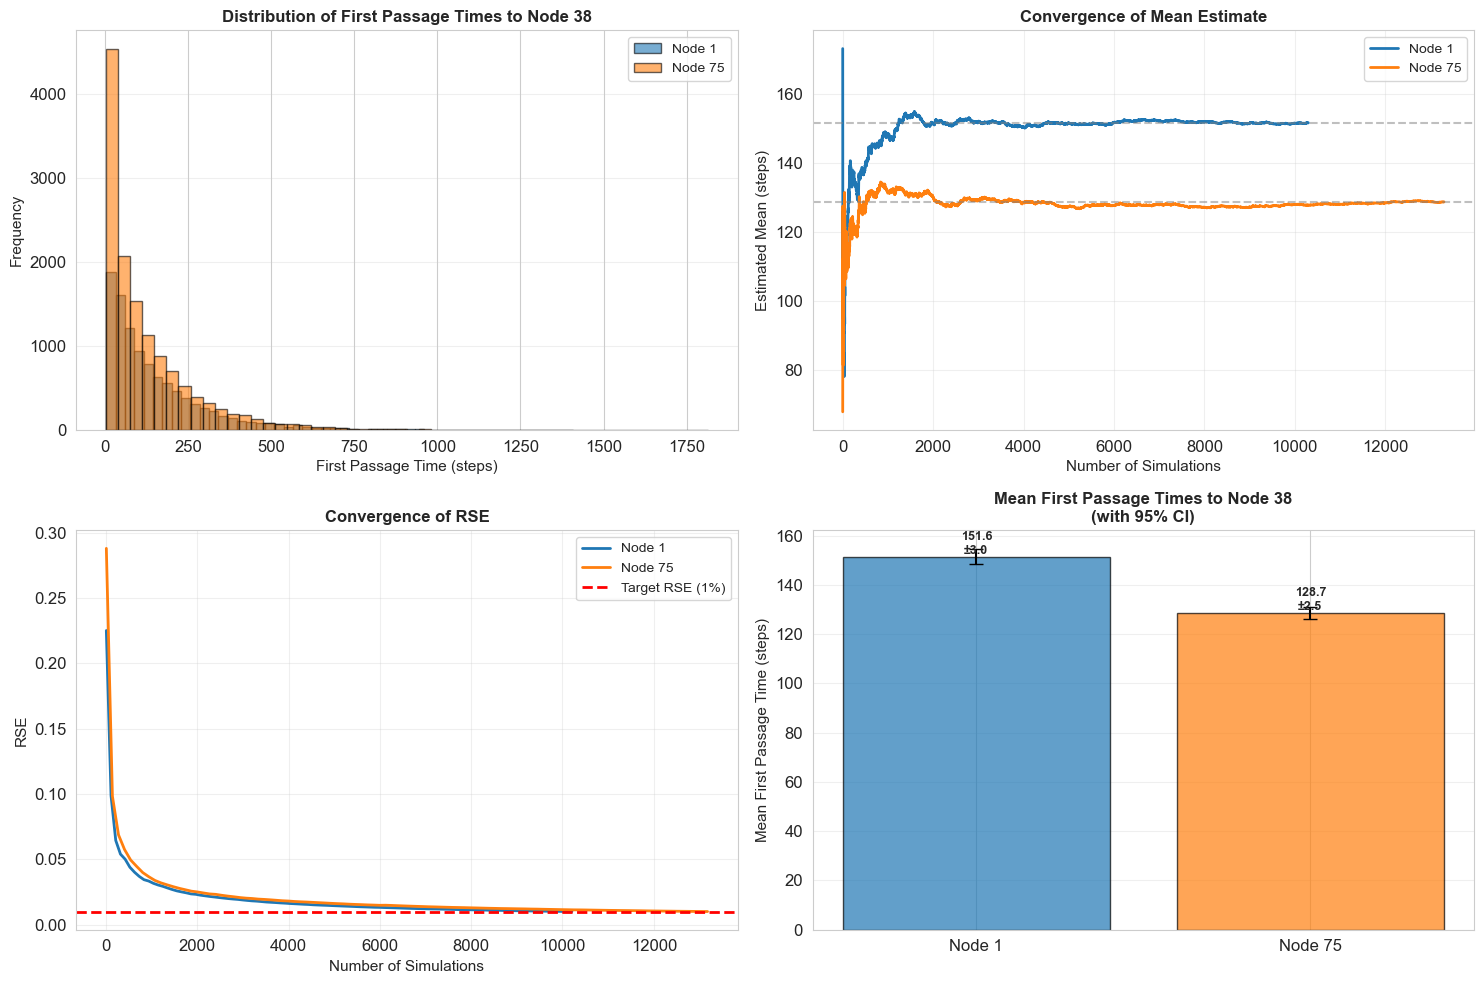

In [32]:
q2_results = question2_simulation(G, network_id)